# Residual creation
In this notebook I will work on creating the residual portfolios based on the historical price dataset.

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
from numpy.linalg import eig, norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import time

In [ ]:
import os
filename = 'price_df.csv'
if os.path.exists(filename):
    price_df = pd.read_csv(filename)
    price_df = price_df.rename(columns={'Unnamed: 0':'date'})
    price_df.set_index('date', inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

returns = price_df.diff(1)

In [ ]:
returns.shape

In [ ]:
returns

In [ ]:
6998*966 - sum(sum(returns.isna().values))

In [ ]:
from tqdm import tqdm 
def pca(returns:pd.DataFrame, res_cov_window_size:int = 252, loadings_window_size:int=60, amount_of_factors:int=5):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    for t in tqdm(range(res_cov_window_size+1,len(returns))):
        # only use the columns with no missing values
        idxsSelected = ~np.any(np.isnan(returns[(t - res_cov_window_size+1):t]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[(t - res_cov_window_size+1):t,idxsSelected]
        R_oos           = returns[((t+1) - res_cov_window_size+1):(t+1),idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        R           = res_cov_window[-loadings_window_size:,:]
        wtR         = res_cov_window[-loadings_window_size:,:] @ w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R_oos[-1,:].T
        residuals_output[t:(t+1),idxsSelected]                = residuals
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[t:(t+1),idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [ ]:
res_out, res_portf = pca(returns.loc[dt.datetime(2010,1,1):dt.datetime(2014,1,2)])

In [ ]:
res_out, _ = pca(returns.loc[dt.datetime(2010,1,1):dt.datetime(2012,1,2)])
test1      = pd.DataFrame(res_out, index = returns.loc[dt.datetime(2010,1,1):dt.datetime(2012,1,2)].index, columns=returns.columns)

In [ ]:
res_out, _ = pca(returns.loc[dt.datetime(2010,1,1)+dt.timedelta(days=100):dt.datetime(2012,1,2)+dt.timedelta(days=100)])
test2      = pd.DataFrame(res_out, index = returns.loc[dt.datetime(2010,1,1)+dt.timedelta(days=100):dt.datetime(2012,1,2)+dt.timedelta(days=100)].index,columns=returns.columns)

In [ ]:
residual_df = pd.DataFrame(res_out, index=returns.loc[dt.datetime(2010,1,1):dt.datetime(2018,1,2)].index, columns=returns.columns)

In [ ]:
residual_df

In [ ]:
plt.plot((residual_df['BRK.B']+1).cumprod().tail(60))

In [ ]:
(residual_df['WFC']+1).cumprod().tail(100)

In [ ]:
price_df.loc[dt.datetime(2017,12,29)]

In [ ]:
def preprocess_ou(data:np.array, lookback:int=60):
    signal_length = 4
    T,N = data.shape
    cumsums = np.cumsum(data, axis=0)
    windows = np.zeros((T-lookback, N, signal_length), dtype=np.float32)
    idxs_selected = np.zeros((T-lookback,N), dtype=bool)
    for t in range(lookback,T):
        # chooses stocks which have no missing returns in the t-th lookback window
        idxs_selected[t-lookback,:] = ~np.any(data[(t-lookback):t,:] == 0, axis=0).ravel() 
        idxs = idxs_selected[t-lookback,:]
        if t == lookback:
            x = cumsums[t-lookback:t,idxs].T
        else:
            # Probably unnecessary given the conv normalization, but is just to have the same setting as in the OU case
            x = cumsums[t-lookback:t,idxs].T - cumsums[t-lookback-1,idxs].reshape(int(sum(idxs)),1)
        Nx,Tx = x.shape
        #TODO: Is this where we make sure we dont have any look ahead bias?
        Ys = x[:,1:] #(N,T-1) 
        Xs = x[:,:-1]
        meansX = np.mean(Xs,axis=1) #(N)
        meansY = np.mean(Ys,axis=1)
        VarsX = np.var(Xs,axis=1) #N
        VarsY = np.var(Ys,axis=1)
        Covs = np.mean((Xs-meansX.reshape((Nx,1)))*(Ys-meansY.reshape((Nx,1))),axis=1) #N
        R2 = Covs**2/(VarsX*VarsY) #N
        bs = Covs/VarsX #N
        cs = (meansY - bs*meansX)
        mus = (cs/(1-bs+0.000001))
        mask = ((bs > 0) * (bs < 1))
        #kappas = -np.log(bs)/Deltat #if bs betwen 0 and 1
        residuals = Ys - bs.reshape((Nx,1))*Xs - cs.reshape((Nx,1)) #(N,T-1)
        sigmas = np.sqrt(np.var(residuals, axis=1)/np.abs(1-bs**2+0.000001)) #N
        signal = np.zeros((Nx))
        #signal =  (mus - Ys[:,-1])/sigmas * mask 
        signal[mask] = (mus[mask] - Ys[:,-1][mask])/sigmas[mask]
        windows[t-lookback,idxs,0] = Ys[:,-1]
        windows[t-lookback,idxs,1] = mus
        windows[t-lookback,idxs,2] = sigmas
        windows[t-lookback,idxs,3] = R2

        idxs_selected[t-lookback,idxs] = idxs_selected[t-lookback,idxs] & mask
        
    idxs_selected = torch.as_tensor(idxs_selected)
    return windows, idxs_selected

In [ ]:
def pca(returns:pd.DataFrame, res_cov_window_size:int = 252, loadings_window_size:int=60, amount_of_factors:int=5):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    for t in tqdm(range(res_cov_window_size+1,len(returns))):
        # only use the columns with no missing values
        idxsSelected = ~np.any(np.isnan(returns[(t - res_cov_window_size+1):t]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[(t - res_cov_window_size+1):t,idxsSelected]
        R_oos           = returns[((t+1) - res_cov_window_size+1):(t+1),idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        R           = res_cov_window[-loadings_window_size:,:]
        wtR         = res_cov_window[-loadings_window_size:,:] @ w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R_oos[-1,:].T
        residuals_output[t:(t+1),idxsSelected]                = residuals
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[t:(t+1),idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [ ]:
def pca_res_gen(price_data:pd.DataFrame, 
                amount_of_factors:int=5,
                loadings_window_size:int=60)-> np.ndarray:
    '''
    Calculates the pca portfolio given a dataset with prices
    '''

    T, N         = price_data.shape 
    assert loadings_window_size < T, 'loading window larger than length of dataset supplied' 

    rets         = price_data.pct_change(1,fill_method=None).iloc[1:].to_numpy()
    idxsSelected = ~np.any(np.isnan(rets), axis = 0).ravel()
    if idxsSelected.sum() == 0:
            return np.zeros((N,N))
    
    rets_is     = rets[:,idxsSelected] # in sample returns: used for generating the portfolio

    # Calculate PCA
    rets_mean   = np.mean(rets_is, axis=0,keepdims=True)
    rets_vol    = np.sqrt(np.mean((rets_is-rets_mean)**2,axis=0,keepdims=True))
    rets_normalized = (rets_is - rets_mean) / rets_vol
    Corr        = np.dot(rets_normalized.T, rets_normalized)
    _, eigenVectors = np.linalg.eigh(Corr)

    # Calculate loadings
    w           = eigenVectors[:,-amount_of_factors:].real  
    R           = rets_is[-loadings_window_size:,:]
    wtR         = R @ w  
    regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
    beta        = regr.coef_                                                    #beta
    psi         = (np.eye(beta.shape[0]) - beta @ w.T)

    # Calculate residual returns
    residual_portf = np.zeros((N,N))
    i = 0
    for idx, val in enumerate(idxsSelected):
         if val:
               residual_portf[idx,idxsSelected] = psi[i,:].reshape([1,-1])
               i += 1
    return residual_portf, idxsSelected

In [154]:
def fourier_signal_extractor(residuals_data:pd.DataFrame, output_size:int=30):
    '''
    All the data input in this function should be considered in sample
    '''
    L, N = residuals_data.shape
    assert L >= output_size, "can't calculate fourier transform for more than the input amount of data"
    res_window = (residuals_data + 1).cumprod().values[1:,:]
    Fourier    = np.fft.rfft(res_window,axis=0)
    n_f        = Fourier.shape[0]
    out        = np.zeros((N,n_f*2))
    out[:,:n_f]= np.real(Fourier).T
    out[:,n_f:]= np.imag(Fourier).T #geen idee maar in andere papers doen ze dit ook
    return out

In [ ]:
res_out, res_portf = pca(returns.loc[dt.datetime(2010,1,1):dt.datetime(2014,1,2)])

In [ ]:
test_data = price_df.tail(252)

In [ ]:
_, test = pca_res_gen(test_data)

In [ ]:
price_df.index[10]

In [155]:
import gym
class TradingEnvironment(gym.Env):
    def __init__(self, 
                 financial_dataset:pd.DataFrame,
                 residual_generator,
                 signal_generator,
                 episode_length:int=100,
                 lookback_window:int=252,
                 signal_window:int=60,
                 transaction_costs:float=0.0,
                 short_cost:float=0.0) -> None:
        '''
        financial_dataset: is a dataframe containing the adjusted prices of all the assets
        residual_generator: a function, called every timestep, whose input is a lookback window of asset prices, and then 
                            calculates the residual portfolios at that time.
        signal_generator:  a function, called every timestep, whose input is a lookback window of residual returns, that extracts 
                            the signal from the lookback window
        '''
        super().__init__()

        self.L, self.N = financial_dataset.shape # amount of datapoints, amount of stocks
        self.data      = financial_dataset  # dataset 
        self.returns   = financial_dataset.pct_change(1,fill_method=None) # compute returns 
        self.res_rets  = pd.DataFrame(index=self.data.index, columns=self.data.columns) # dataframe used to store the residual returns
        self.res_alloc = pd.DataFrame(index=self.data.index, columns=self.data.columns) # dataframe used to store the chosen allocation per residual portfolio
        self.asset_alloc= pd.DataFrame(index=self.data.index, columns=self.data.columns) # dataframe used to store the allocation in the original asset space
        self.total_pl  = pd.DataFrame(index=self.data.index, columns=['strategy'])

        # both generic functions so they can be swapped in the future
        self.res_gen   = residual_generator 
        self.sig_gen   = signal_generator

        self.ep_N      = episode_length    # amount of timesteps until an 'episode' is over
        self.tc        = transaction_costs # transaction cost used
        self.sc        = short_cost        # cost to keep a short position
        self.lbw       = lookback_window   # lookback window used for pca 
        self.sig_win   = signal_window     # lookback window used for signals

        self.t         = self.lbw + 1 #current timestep idx position in the large dataset
        self.ep        = 0  # current episode
        self.max_ep    = (self.L - self.lbw - self.sig_win) // self.ep_N # maximal amount of episodes possible with the data

        self.t_ep    = 0 # current timestep in the epsisode (max is self.ep_N)
        
        # setup the environment to begin
        self.warm_up()

    def warm_up(self):
        # if at initialisation
        assert self.ep == 0

        self.res_portf     = np.zeros((self.N,self.N))
        self.active_stocks = np.zeros((self.N,),dtype=bool)
        
        for _ in range(self.sig_win):
            # start by computing the residual returns
            self.iter_step()
            self.res_rets_step()

            # calculate the new residual portfolio weights at time t (in pandas :t+1, means the last row is at time t)
            self.res_portf, self.active_stocks  = self.res_gen(self.data.iloc[self.t - self.lbw: self.t+1],
                                                        amount_of_factors=5,
                                                        loadings_window_size=self.sig_win)
        
        # initialise the allocation vectors 
        self.old_alloc       = np.zeros((self.N,self.N))
        self.old_alloc_total = np.zeros((self.N,))

        observation = None #self.sig_gen(self.rets.iloc[self.t - self.sig_win:self.t])
        info = {'used_stocks': self.active_stocks}
        return observation, info
    
    def res_rets_step(self):
        self.res_portf_previous = self.res_portf.copy()
        self.res_rets.iloc[self.t,self.active_stocks] = (self.res_portf @ \
                        self.returns.iloc[self.t].replace(np.nan,0).values)[self.active_stocks]
        
    def iter_step(self):
        '''
        keeps track of all timesteps
        '''
        self.t    += 1
        self.t_ep += 1
        if self.t_ep >= self.ep_N:
            self.ep += 1

    @property
    def date(self):
        return self.data.index[self.t]
    
    @property
    def tradable_ticker(self):
        return self.data.columns[self.active_stocks]

    def _get_next_obs(self):
        # the the returns at time (t) from the residual portfolios generated at time (t-1)
        # generate the signal vector from the residual portfolio returns 
        # generate the new residual portfolios to trade in
        obs = self.sig_gen(self.res_rets.iloc[self.t - self.sig_win: self.t + 1, self.active_stocks])
        return obs

    def calculate_transaction_cost(self):
        '''
        This calculation is based on the market friction model from Boyd et al. (2017)

        tc_vector contains the individual transaction costs incurred by trading in each of the portfolios
        tc_total is a real that contains the true total transaction cost incurred by the 
        '''
        tc_vector = self.tc * np.linalg.norm(self.new_alloc - self.old_alloc,1,axis=1) \
                        + self.sc * np.linalg.norm(np.minimum(self.new_alloc, np.zeros((self.N,self.N))))

        tc_total = self.tc * np.linalg.norm(self.new_alloc_total -self.old_alloc_total,1) \
                        + self.sc * np.linalg.norm(np.minimum(self.new_alloc_total, np.zeros(self.N)))
        return tc_vector, tc_total
    
    def step(self,action):
        '''
        Action is a vector of size N_t, the size of which can vary according to the active stocks at the time
        it represents the chosen loadings in the residual portfolios. 

        The reward will be a vector of the rewards generated by the individual portfolios and their allocation, and 
        will be be returned to the reinforcement learning agent as a reward signal.
        However, in the real environment there is a shared portfolio that will also be updated.
        '''
        assert len(action) == sum(self.active_stocks), 'wrong size of action/allocation vector supplied'

        ########### Time: t-1 #############

        # "invest" the chosen amount Action
        allocation_in_residuals = np.zeros((self.N,1))
        allocation_in_residuals[self.active_stocks] = action

        # calculate the new allocation in terms of the true asset space
        self.new_alloc = (self.res_portf * np.tile(allocation_in_residuals, (1, self.N)))                 # per residual portf.
        self.new_alloc_total  = self.new_alloc.sum(axis=0) 
        self.new_alloc_total /= np.linalg.norm(self.new_alloc_total,1)  # for the entire (normalized) portf.

        # we incur a transaction cost through this new allocation
        self.tc_vector, self.tc_total = self.calculate_transaction_cost()

        ########### Time: t  #############
        # then we need to step
        self.iter_step()
        self.res_rets_step()
        
        # now calculate the effect of the allocation for each individual stock 
        #TODO: debug this!!
        portf_change  = self.new_alloc @ self.returns.iloc[self.t].replace(np.nan,0).values
        reward        = portf_change - self.tc_vector

        # calculate the general profit made by the whole portfolio
        change_total  = self.new_alloc_total @ self.returns.iloc[self.t].replace(np.nan,0).values
        p_l           = change_total - self.tc_total
        self.total_pl.loc[self.date, 'strategy']  = p_l

        # save the old allocations and store them 
        self.old_alloc       = self.new_alloc.copy()
        self.old_alloc_total = self.new_alloc_total.copy()
        self.res_alloc.loc[self.date] = allocation_in_residuals.flatten()
        self.asset_alloc.loc[self.date] = self.new_alloc_total.flatten()

        # prepare the next observation, the new returns were already calulated in res_rets_step
        observation = self._get_next_obs()

        # calculate the new residual portfolio weights at time t
        self.res_portf, self.active_stocks  = self.res_gen(self.data.iloc[self.t - self.lbw: self.t+1],
                                                    amount_of_factors=5,
                                                    loadings_window_size=self.sig_win)

        if self.t % self.ep_N == 0:
            done = True
        else:
            done = False
        info = {}
        return observation, reward, done, info

In [156]:
env = TradingEnvironment(financial_dataset=price_df,
                        residual_generator=pca_res_gen,
                        signal_generator=fourier_signal_extractor,
                        episode_length=100,
                        lookback_window=252,
                        signal_window=60,
                        transaction_costs=0.0,
                        short_cost=0.0)

In [157]:
from tqdm import tqdm
for _ in tqdm(range(1)):
    n = sum(env.active_stocks)
    #obs, rew, d, inf = env.step(np.random.uniform(-1,1,(n,1)))
    obs, rew, d, inf = env.step(np.ones((n,1)))
env.total_pl.loc[env.date]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


strategy   -0.000025
Name: 1997-03-31 00:00:00, dtype: object

In [161]:
obs[:,31] #TODO fix dit probleem

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [164]:
obs[:,61]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
env.date

In [119]:
price_df[env.res_rets.columns[num]].dropna()

date
2017-10-13    58.74
2017-10-16    58.92
2017-10-17    58.61
2017-10-18    57.47
2017-10-19    54.17
              ...  
2023-10-12    15.49
2023-10-13    14.86
2023-10-16    14.96
2023-10-17    15.14
2023-10-18    14.32
Name: NCLH, Length: 1513, dtype: float64

Text(0.5, 1.0, 'ANDW')

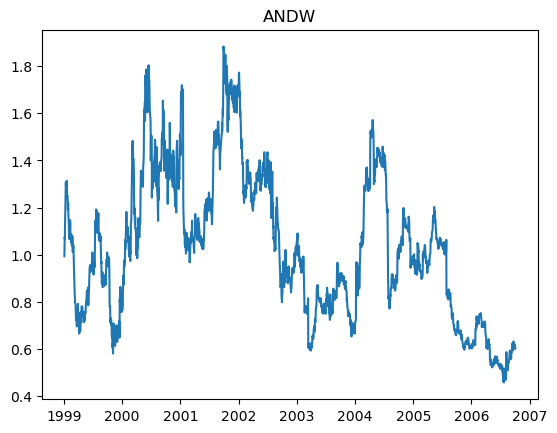

In [123]:
num = 904
plt.plot((env.res_rets[env.res_rets.columns[num]].dropna() +1).cumprod())
plt.title(env.res_rets.columns[num])

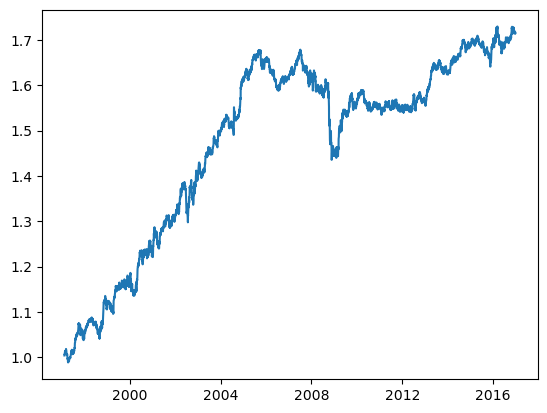

In [118]:
plt.plot((env.total_pl.dropna() + 1).cumprod())

In [ ]:
env.tradable_ticker